In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(10)

In [ ]:
# Load Training Set
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ETF_Price_Predict/0050_all_data.csv", index_col="Date", parse_dates=True)
df = df.dropna()
# check null
null_values = df.isnull()
print(null_values.sum())

Mounted at /content/drive
History Closing Price              0
VIX Index                          0
Fed Funds Rate                     0
Closing Price                      0
Volume                             0
Foreign Investor Trading Volume    0
Business Climate Indicator         0
Composite Leading Indicator        0
Outlook for the Next Six Months    0
Manufacturing PMI                  0
New Export Orders                  0
CPI Annual Growth Rate             0
Consumer Price Index               0
dtype: int64


In [ ]:
# serialize data
sc_features = MinMaxScaler()
sc_target = MinMaxScaler()

# 70% is training data 。20 percent is verification data 。10 percent is test data
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
# The remaining 10% will go into Test
# Split the data
df_train = df[:train_size]
df_validation = df[train_size:train_size+val_size]
df_test = df[train_size+val_size:]
print("train No.:",len(df_train))
print("val No.:",len(df_validation))
print("test No.:",len(df_test))

# History Closing Price
# VIX Index
# Fed Funds Rate
# Volume
# Foreign Investor Trading Volume
# Business Climate Indicator
# Composite Leading Indicator
# Outlook for the Next Six Months
# Manufacturing PMI
# New Export Orders
# CPI Annual Growth Rate
# Consumer Price Index
# Closing Price

# ####################################################################################
x_columns = ['Closing Price','Volume','VIX Index']
# ####################################################################################
#'Business Climate Indicator','Composite Leading Indicator','Outlook for the Next Six Months','New Export Orders','Manufacturing PMI'
y_column = 'Closing Price'

X_train_set = df_train[x_columns].values
#X_train_set = df_train[['History Closing Price','VIX Index', 'Fed Funds Rate', 'Volume','Foreign Investor Trading Volume','Business Climate Indicator','Composite Leading Indicator',
#                        'Outlook for the Next Six Months','Manufacturing PMI','New Export Orders','CPI Annual Growth Rate','Consumer Price Index']].values
# Closing Price
Y_train_set = df_train[y_column].values.reshape(-1,1)

X_train_set_scaled = sc_features.fit_transform(X_train_set)
Y_train_set_scaled = sc_target.fit_transform(Y_train_set)
print(X_train_set_scaled.shape)
print(Y_train_set_scaled.shape)


train No.: 715
val No.: 204
test No.: 103
(715, 3)
(715, 1)


In [ ]:
X_validation_set = df_validation[x_columns].values
Y_validation_set = df_validation[y_column].values.reshape(-1,1)

X_validation_set_scaled = sc_features.transform(X_validation_set)
Y_validation_set_scaled = sc_target.transform(Y_validation_set)

In [ ]:
def create_dataset(X, Y, look_back=1, steps_ahead=5):
    X_data, Y_data = [], []
    for i in range(len(X) - look_back - steps_ahead + 1):
        a = X[i:(i + look_back), :]
        X_data.append(a)
        Y_data.append(Y[i + look_back:i + look_back + steps_ahead])
    return np.array(X_data), np.array(Y_data)

look_back=5
##########################According predict day, change look day day ################################################
steps_ahead=5
#####################################################################################################################

X_train, Y_train = create_dataset(X_train_set_scaled, Y_train_set_scaled, look_back, steps_ahead)
X_validation, Y_validation = create_dataset(X_validation_set_scaled, Y_validation_set_scaled, look_back, steps_ahead)


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_validation.shape)
print(Y_validation.shape)



(706, 5, 3)
(706, 5, 1)
(195, 5, 3)
(195, 5, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             17408     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 3

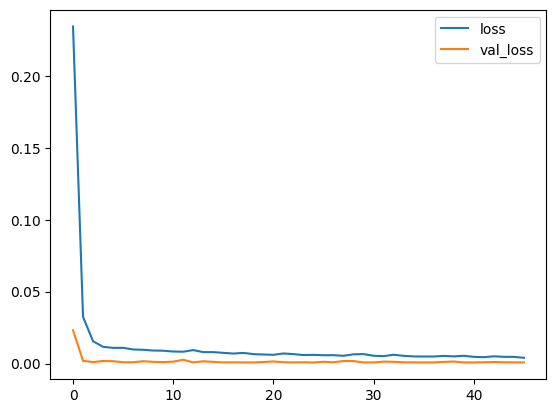

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

model = Sequential()
model.add(LSTM(units=64,
               return_sequences=True,
               input_shape=(look_back, len(x_columns))))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))

model.add(Dense(steps_ahead))


model.compile(optimizer='adam', loss='mse')
model.summary()

# EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
# Train Model
##########################根據測試需要, 調整 epochs 範圍################################################################################
history=model.fit(X_train, Y_train, validation_data=(X_validation,Y_validation),epochs=100, batch_size=32, callbacks=[early_stopping])
######################################################################################################################################

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();


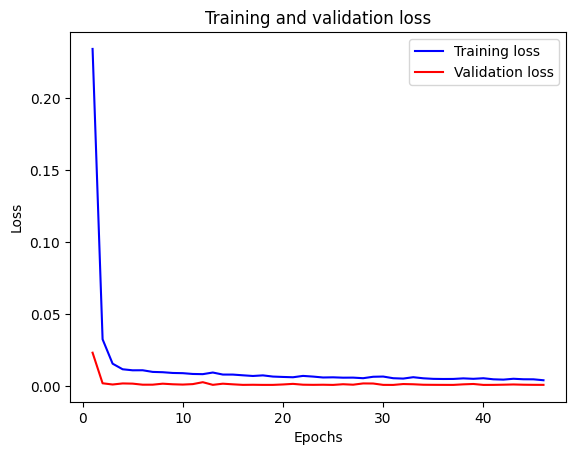

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Create diagram
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show Diagram
plt.show()

In [ ]:
X_test_set = df_test[x_columns].values
Y_test_set = df_test[y_column].values.reshape(-1,1)

X_test_set_scaled = sc_features.transform(X_test_set)
Y_test_set_scaled = sc_target.transform(Y_test_set)


X_test, Y_test = create_dataset(X_test_set_scaled, Y_test_set_scaled, look_back,steps_ahead)

print("X_test shape:", X_test.shape)  # Expect: (num_samples, look_back, num_features)
print("Y_test shape:", Y_test.shape)  # Expect: (num_samples, 5)

X_test shape: (94, 5, 3)
Y_test shape: (94, 5, 1)


In [ ]:
test_predicted_stock_price = model.predict(X_test)

test_predicted_stock_price = sc_target.inverse_transform(test_predicted_stock_price.reshape(-1, 1)).reshape(-1, steps_ahead)
# Note: Y_test might need reshaping or similar handling depending on how your scaler was fit and inverse_transform is handled
Y_test_reshaped = Y_test.reshape(-1, steps_ahead)
Y_test_rescaled = sc_target.inverse_transform(Y_test_reshaped.reshape(-1, 1)).reshape(-1, steps_ahead)

print(test_predicted_stock_price[0:5])
print(Y_test_rescaled[0:5])

3/3 [==============================] - 2s 9ms/step
[[125.70383  126.55124  126.65364  126.48823  126.13635 ]
 [125.2538   126.10445  126.2149   126.03815  125.695145]
 [124.589676 125.45856  125.568214 125.383484 125.049355]
 [124.49164  125.35774  125.48628  125.286644 124.95799 ]
 [124.14937  125.00628  125.13283  124.94547  124.61231 ]]
[[123.85 123.95 124.2  121.75 122.3 ]
 [123.95 124.2  121.75 122.3  122.  ]
 [124.2  121.75 122.3  122.   121.15]
 [121.75 122.3  122.   121.15 121.75]
 [122.3  122.   121.15 121.75 124.5 ]]


In [ ]:
mae = mean_absolute_error(Y_test_rescaled, test_predicted_stock_price)
mse = mean_squared_error(Y_test_rescaled, test_predicted_stock_price)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_rescaled, test_predicted_stock_price)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 2.7770188449291475
Mean Squared Error (MSE): 13.198508559388838
Root Mean Squared Error (RMSE): 3.6329751663600507
R-squared (R²): 0.7873513319343524


In [ ]:
last_sequence = X_test[-1:]  # Get the last sequence from X_test
next_days_prediction_scaled = model.predict(last_sequence)
next_days = sc_target.inverse_transform(next_days_prediction_scaled)[:, :steps_ahead]

days_str = str(steps_ahead)
print("Next " + days_str + " days predictions:")
print(next_days)

1/1 [==============================] - 0s 22ms/step
Next 5 days predictions:
[[149.54185 150.27054 149.87146 149.96527 149.36366]]


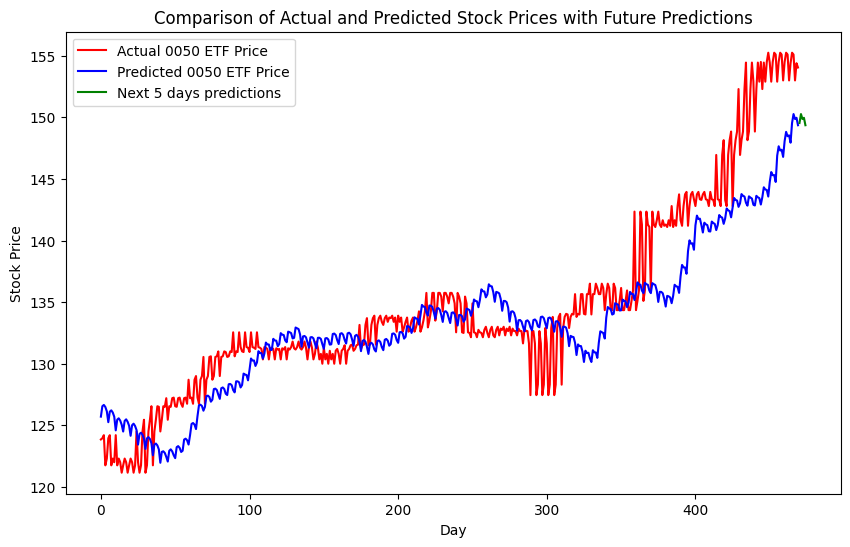

In [ ]:
# Visualization of TEST results
future_length = len(next_days.flatten())
test_length = len(Y_test_rescaled.flatten())

# Create x-axis values
x_test_days = np.arange(test_length)
x_future_days = np.arange(test_length, test_length + future_length)

plt.figure(figsize=(10, 6))
plt.plot(x_test_days, Y_test_rescaled.flatten(), 'r-', label="Actual 0050 ETF Price")
plt.plot(x_test_days, test_predicted_stock_price.flatten(), 'b-', label="Predicted 0050 ETF Price")
# Plot the predictions for the next five days
plt.plot(x_future_days, next_days.flatten(), 'g-', label="Next 5 days predictions")
plt.title("Comparison of Actual and Predicted Stock Prices with Future Predictions")
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.legend()
# Save the figure before showing it
plt.savefig("/content/drive/My Drive/Colab Notebooks/ETF_Price_Predict/0050_ETF_Price_Prediction.png")
plt.show()

In [ ]:
# Save the price to googel drive
#next_day_price = predict_next_day_price(model, df_test, look_back, sc_features, sc_target)
#price=round(float(next_day_price),2)

#print(f"Predict next day price: {price}")

# Save the diagram to google drive
#df_pred = pd.DataFrame([[price]])
#df_pred.to_excel('/content/drive/My Drive/Colab Notebooks/ETF_Price_Predict/0050.xlsx', index=False, header=False)

#print('Already save ',price,' 至 0050.xlsx')